In [1]:
import os 
import pathlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

from tensorflow.keras.models import Sequential

from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.applications.efficientnet import preprocess_input

# For building and loading the EfficientNet model
from tensorflow.keras.applications import EfficientNetB2  # Can change B2 to any other version as needed
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D,Dropout


In [2]:
def load_and_preprocess_data(data):
    images = []
    labels = []
    for label, image_paths in data.items():
        for path in image_paths:
            img = cv2.imread(str(path))
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert image to RGB format
            img = cv2.resize(img, (260, 260))  # Resize image to VGG19 input size
            images.append(img)
            labels.append(label)
    images = np.array(images)
    labels = np.array(labels)
    return images, labels

In [3]:
path = pathlib.Path(r"kvasir-dataset")

In [4]:
dyed_ifted_polyps = list(path.glob('dyed-lifted-polyps/*'))
dyed_resection_margins = list(path.glob('dyed-resection-margins/*'))
esophagitis = list(path.glob('esophagitis/*'))
normal_cecum = list(path.glob('normal-cecum/*'))
normal_pylorus = list(path.glob('normal-pylorus/*'))
normal_z_line = list(path.glob('normal-z-line/*'))
polyps = list(path.glob('polyps/*'))
ulcerative_colitis = list(path.glob('ulcerative-colitis/*'))

In [5]:
data = {
    'dyed-lifted-polyps' : dyed_ifted_polyps ,
    'dyed-resection-margins' : dyed_resection_margins,
    'esophagitis' : esophagitis,
    'normal-cecum' : normal_cecum,
    'normal-pylorus' : normal_pylorus,
    'normal-z-line' : normal_z_line,
    'polyps' : polyps,
    'ulcerative-colitis' : ulcerative_colitis
}

polys_labels = {
    0:'dyed-lifted-polyps',
    1:'dyed-resection-margins',
    2:'esophagitis',
    3:'normal-cecum',
    4:'normal-pylorus',
    5:'normal-z-line',
    6:'polyps',
    7:'ulcerative-colitis'
}

In [6]:
images, labels = load_and_preprocess_data(data)

In [7]:
# Split the data into training, validation, and testing sets
train_data, test_data, train_labels, test_labels = train_test_split(images, labels, test_size=0.2, random_state=42)
train_data, val_data, train_labels, val_labels = train_test_split(train_data, train_labels, test_size=0.2, random_state=42)

In [8]:
train_data_efficient = preprocess_input(train_data)
val_data_efficient = preprocess_input(val_data)
test_data_efficient = preprocess_input(test_data)

In [9]:
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_labels)
val_labels_encoded = label_encoder.transform(val_labels)
test_labels_encoded = label_encoder.transform(test_labels)

In [10]:
base_model = EfficientNetB2(weights='imagenet', include_top=False, input_shape=(260, 260, 3))  # Adjust the input shape for EfficientNetB2

# Freeze the base model layers
base_model.trainable = False

# Create the model
model_efficientnetb2 = Sequential([
    base_model,
    GlobalAveragePooling2D(),  # Using GlobalAveragePooling2D instead of Flatten for better handling of the features
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(8, activation='softmax')  # Adjust the output units based on the number of classes
])

31790344/31790344 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [11]:
model_efficientnetb2.compile(optimizer=Adam(learning_rate=0.001),
                             loss='sparse_categorical_crossentropy',
                             metrics=['accuracy'])

In [12]:
history_efficientnetb2 = model_efficientnetb2.fit(
    train_data_efficient, 
    train_labels_encoded,  
    epochs=10,
    batch_size=32,
    validation_data=(val_data_efficient, val_labels_encoded)  # Make sure validation data has also been preprocessed
)

Epoch 1/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 63s 610ms/step - accuracy: 0.5575 - loss: 1.1775 - val_accuracy: 0.8422 - val_loss: 0.4323
Epoch 2/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 45s 565ms/step - accuracy: 0.8392 - loss: 0.4247 - val_accuracy: 0.8547 - val_loss: 0.3906
Epoch 3/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 47s 594ms/step - accuracy: 0.8427 - loss: 0.3970 - val_accuracy: 0.8703 - val_loss: 0.3648
Epoch 4/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 47s 583ms/step - accuracy: 0.8681 - loss: 0.3662 - val_accuracy: 0.8719 - val_loss: 0.3379
Epoch 5/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 46s 581ms/step - accuracy: 0.9004 - loss: 0.2549 - val_accuracy: 0.8641 - val_loss: 0.3349
Epoch 6/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 46s 577ms/step - accuracy: 0.8912 - loss: 0.2704 - val_accuracy: 0.8750 - val_loss: 0.3458
Epoch 7/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 47s 587ms/step - accuracy: 0.8968 - loss: 0.2470 - val_accuracy: 0.8750 - val_loss: 0.3324
Epoch 8/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 46s 571ms/step - accuracy: 0.9078 - loss: 0.2419 - val_accu

In [13]:
test_loss, test_acc = model_efficientnetb2.evaluate(test_data_efficient, test_labels_encoded)
print(f'Test Accuracy: {test_acc}')

25/25 ━━━━━━━━━━━━━━━━━━━━ 32s 1s/step - accuracy: 0.8728 - loss: 0.3493
Test Accuracy: 0.8600000143051147


In [14]:
model_efficientnetb2.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ efficientnetb2 (Functional)          │ (32, 9, 9, 1408)            │       7,768,569 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (32, 1408)                  │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (32, 256)                   │         360,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (32, 256)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (32, 8)                     │           2,056 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,856,851 (33.79 MB)

 Trainable params: 362,760 (1.38 MB)

 Non-trainable params: 7,768,569 (29.63 MB)

 Optimizer params: 725,522 (2.77 MB)

In [15]:
import numpy as np
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.applications.efficientnet import preprocess_input, EfficientNetB2  # Import EfficientNetB2 and its preprocess_input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout, GlobalAveragePooling2D  # Use GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam

# Define the number of folds for cross-validation
num_folds = 5

# Define your EfficientNetB2 base model
base_model = EfficientNetB2(weights='imagenet', include_top=False, input_shape=(260, 260, 3))  # Adjust input shape for EfficientNetB2

# Freeze the base model layers
base_model.trainable = False

# Define the number of classes
num_classes = 8  # Update with the number of classes in your dataset

# Define a function to create the EfficientNetB2 model
def create_efficientnetb2_model():
    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),  # Recommended over Flatten for EfficientNet
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    return model

# Perform cross-validation
skf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)
cv_scores = []

for fold, (train_index, val_index) in enumerate(skf.split(train_data, train_labels_encoded)):
    print(f"Fold {fold + 1}/{num_folds}")
    
    # Create EfficientNetB2 model
    model = create_efficientnetb2_model()
    
    # Compile the model
    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    
    # Preprocess training and validation data
    train_data_preprocessed = preprocess_input(train_data[train_index])
    val_data_preprocessed = preprocess_input(train_data[val_index])
    
    # Train the model
    model.fit(train_data_preprocessed, train_labels_encoded[train_index], epochs=5, batch_size=50, verbose=1,
              validation_data=(val_data_preprocessed, train_labels_encoded[val_index]))
    
    # Evaluate the model on validation data
    val_loss, val_acc = model.evaluate(val_data_preprocessed, train_labels_encoded[val_index], verbose=0)
    print(f"Validation Accuracy: {val_acc}")
    cv_scores.append(val_acc)

# Calculate and print the mean cross-validation score
mean_cv_score = np.mean(cv_scores)
print(f"Mean Cross-Validation Accuracy: {mean_cv_score}")

Fold 1/5
Epoch 1/5
41/41 ━━━━━━━━━━━━━━━━━━━━ 272s 3s/step - accuracy: 0.4785 - loss: 1.3975 - val_accuracy: 0.8496 - val_loss: 0.4566
Epoch 2/5
41/41 ━━━━━━━━━━━━━━━━━━━━ 104s 3s/step - accuracy: 0.8104 - loss: 0.4994 - val_accuracy: 0.8711 - val_loss: 0.3919
Epoch 3/5
41/41 ━━━━━━━━━━━━━━━━━━━━ 117s 3s/step - accuracy: 0.8648 - loss: 0.3809 - val_accuracy: 0.8789 - val_loss: 0.3578
Epoch 4/5
41/41 ━━━━━━━━━━━━━━━━━━━━ 87s 2s/step - accuracy: 0.8793 - loss: 0.3428 - val_accuracy: 0.8672 - val_loss: 0.3482
Epoch 5/5
41/41 ━━━━━━━━━━━━━━━━━━━━ 87s 2s/step - accuracy: 0.8800 - loss: 0.3064 - val_accuracy: 0.8672 - val_loss: 0.3438
Validation Accuracy: 0.8671875
Fold 2/5
Epoch 1/5
41/41 ━━━━━━━━━━━━━━━━━━━━ 181s 3s/step - accuracy: 0.4989 - loss: 1.3574 - val_accuracy: 0.8340 - val_loss: 0.4450
Epoch 2/5
41/41 ━━━━━━━━━━━━━━━━━━━━ 88s 2s/step - accuracy: 0.7940 - loss: 0.5096 - val_accuracy: 0.8730 - val_loss: 0.3393
Epoch 3/5
41/41 ━━━━━━━━━━━━━━━━━━━━ 88s 2s/step - accuracy: 0.8490 - lo

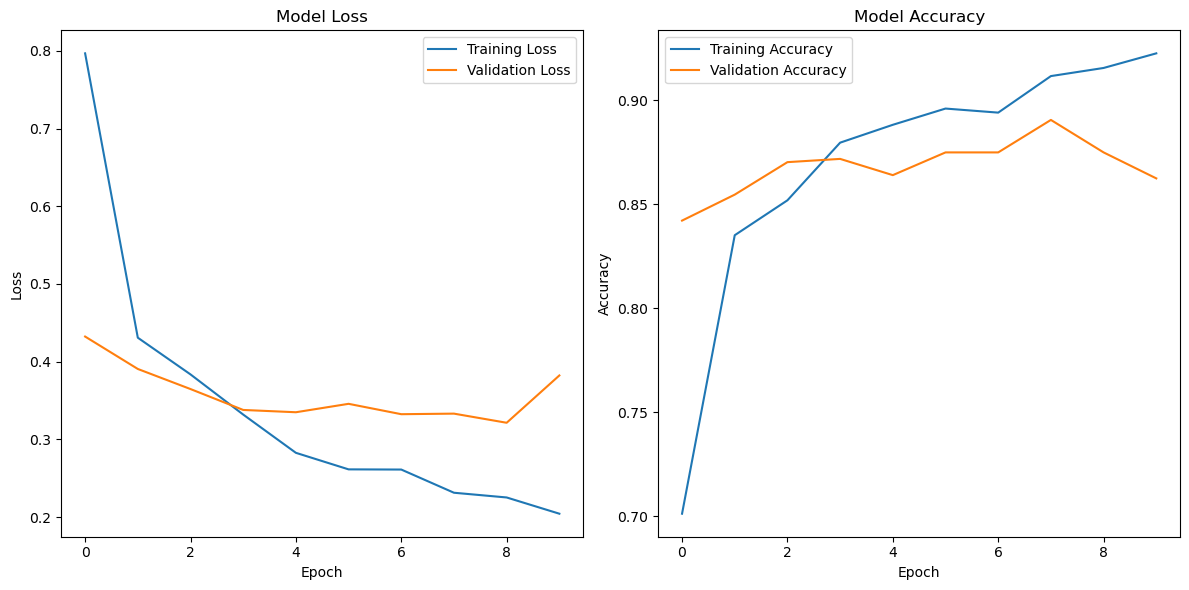

In [16]:
plt.figure(figsize=(12, 6))

# Plot training & validation loss values
plt.subplot(1, 2, 1)
plt.plot(history_efficientnetb2.history['loss'], label='Training Loss')
plt.plot(history_efficientnetb2.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot training & validation accuracy values
plt.subplot(1, 2, 2)
plt.plot(history_efficientnetb2.history['accuracy'], label='Training Accuracy')
plt.plot(history_efficientnetb2.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

25/25 ━━━━━━━━━━━━━━━━━━━━ 24s 746ms/step


<Figure size 800x800 with 0 Axes>

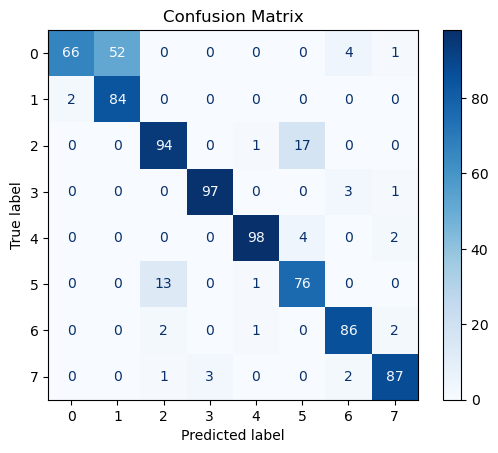

In [18]:
predictions = model_efficientnetb2.predict(test_data_efficient)  # Make sure test_data_efficient is preprocessed
predicted_labels = np.argmax(predictions, axis=1)

# Assuming test_labels_encoded are your true encoded labels for the test set
cm = confusion_matrix(test_labels_encoded, predicted_labels)
classes = [str(i) for i in range(num_classes)]  # Adjust num_classes as necessary

# Plot confusion matrix
plt.figure(figsize=(8, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

In [19]:
from sklearn.metrics import precision_score, recall_score

# Compute Precision and Recall for multiclass classification
precision = precision_score(test_labels_encoded, predictions.argmax(axis=1), average='macro')
recall = recall_score(test_labels_encoded, predictions.argmax(axis=1), average='macro')

print(f'Precision: {precision}')
print(f'Recall: {recall}')

Precision: 0.8759162452334658
Recall: 0.8725377823205835


ROC AUC Score: 0.9917706536119002


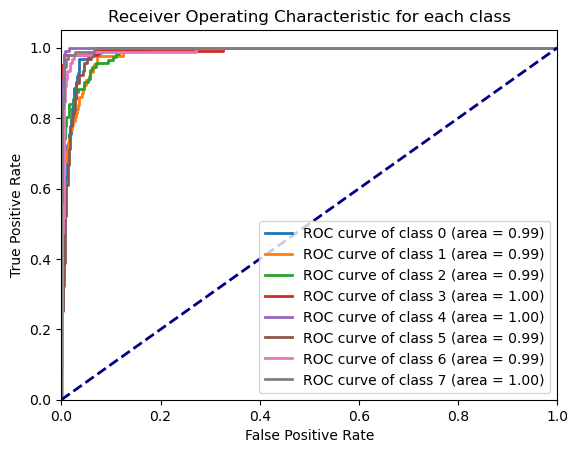

In [20]:
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.preprocessing import label_binarize
import numpy as np
import matplotlib.pyplot as plt

# Binarize the true labels
y_test_binarized = label_binarize(test_labels_encoded, classes=np.unique(test_labels_encoded))

# Calculate AUC for each class
roc_auc = roc_auc_score(y_test_binarized, predictions, multi_class='ovr')

print(f'ROC AUC Score: {roc_auc}')

# Plot ROC curve for each class
n_classes = y_test_binarized.shape[1]
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], predictions[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plotting
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for each class')
plt.legend(loc="lower right")
plt.show()

In [21]:
model_efficientnetb2.save('efficientnetb2.keras')